In [3]:
#Imports and dependencies
import os
from os.path import join, abspath, dirname
import sys
sys.path.insert(0, abspath(join("..", dirname(os.getcwd()))))
          
import cv2
import random
import torch
import torch.nn as nn
import math
import pandas as pd
from PIL import Image, ImageOps
import itertools
from skimage import img_as_ubyte
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.transforms import Rotate, Translate, RotateAxisAngle, Transform3d
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.visualization import plot_pointcloud
from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

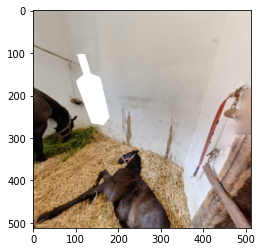

In [48]:
path1 = "../data/renders/train/005-bottle_square_2020-09-07T15:56:41/phong/100_phong.png"
path2 = "../data/renders/train/005-bottle_square_2020-09-07T15:56:41/phong/1_phong.png"
path3 = "../data/renders/train/005-bottle_square_2020-09-07T15:56:41/phong/1_phong.png"

def background_generator():
        background_folder = "../data/background"
        files = os.listdir(background_folder)
        rand_file = random.randint(0, len(files))
        rand_file_path = abspath(join(background_folder, files[rand_file]))
        for img in sorted(os.listdir(rand_file_path)):
            path_img = join(rand_file_path, img)
            img = Image.open(path_img).resize((512, 512))
            yield np.array(img)

background = background_generator()

img1 = cv2.imread(path1) * 255
img2 = cv2.imread(path2) * 255

alpha = img1[..., -1:]
image_bg = next(background) / 255.0


img1_thresh = (img1 > 1) * 255
ret, img2_thresh = cv2.threshold(img2, 1, 2, cv2.THRESH_BINARY)

#np.clip(img1_thresh[...,:3]*alpha+image_bg*(1-alpha), 0, 1)
#np.clip(img1[...,0], 0, 255, out=img1[...,0])
#np.clip(img2[...,0], 0, 255, out=img2[...,0])

plt.imshow(image)

img_add = next(background) + np.array(img1_thresh)
img_add = np.clip(img_add, 0, 255)

plt.imshow(img_add)
plt.show()

In [52]:
meshes_path = "../data/meshes"
meshes_files = [join(meshes_path, mesh) for mesh in os.listdir(meshes_path) if mesh.endswith(".obj")]

In [53]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['figure.dpi'] = 90
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### PARAMS

In [54]:
@dataclass
class EsimParams:
    
    Cp: float = 0.03
    Cn: float = 0.03
    sigma_cp: float = 0.05
    sigma_cn: float = 0.05
    refractory_period: float = 1e-4
    log_eps: float = 1e-3
    use_log: bool = True
    
    show_frame: bool = False
        
@dataclass
class RenderParams:
    
    img_size: int = (512, 512)
    sigma_hand: float = .15
    
    #Size of the dataset
    batch_size: int = 240
    mesh_iter: int = 5
        
    show_frame: bool = True

### Load Objects and scale normalize

In [55]:
#Load the object without textures and materials
meshes = {}
for path in meshes_files:
    verts, faces_idx, _ = load_obj(path)
    faces = faces_idx.verts_idx

    # Scale normalize the target mesh to fit in a sphere of radius 1 centered at (0,0,0)
    center = verts.mean(0)
    verts = verts - center
    scale = max(verts.abs().max(0)[0])
    verts = verts / scale

    # Initialize each vertex to be white in color.
    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    # Create a Meshes object for the teapot. Here we have only one mesh in the batch.
    mesh_name = path.split("/")[-1].split(".")[0]
    meshes[mesh_name] = Meshes(
            verts=[verts.to(device)],   
            faces=[faces.to(device)], 
            textures=textures
        )
    


### Create a Renderer

In [56]:
cameras = SfMPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size= RenderParams.img_size[0], 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=RenderParams.img_size[0], 
    blur_radius=0.0, 
    faces_per_pixel=100, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((0., 0.0, -0.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras)
)

In [57]:
import esim_py

def generate_events(image_path_list):
    
    timestamp_list = range(len(image_path_list)) #let's see if this works

    esim = esim_py.EventSimulator(
        EsimParams.Cp,
        EsimParams.Cn, 
        EsimParams.refractory_period, 
        EsimParams.log_eps, 
        EsimParams.use_log,
        EsimParams.sigma_cp, 
        EsimParams.sigma_cn
    )
    
    events = esim.generateFromStampedImageSequence(
        image_path_list, 
        timestamp_list)
    
    batch_events_plot = int(len(events) / len(image_path_list))

    event_frames = []
    event_batch_size = 0
    while event_batch_size <= len(events) and \
        len(event_frames) < len(image_path_list):
        
        curr_batch_events = events[event_batch_size: event_batch_size + batch_events_plot]
        
        pos_events = curr_batch_events[curr_batch_events[:,-1] == 1]
        neg_events = curr_batch_events[curr_batch_events[:,-1] == -1]

        image_pos = np.zeros(
            RenderParams.img_size[0] * RenderParams.img_size[1], dtype="uint8")
        image_neg = np.zeros(
            RenderParams.img_size[0] * RenderParams.img_size[1], dtype="uint8")

        np.add.at(
            image_pos, 
            (pos_events[:,0]+pos_events[:,1]*RenderParams.img_size[1]).astype("int32"), 
            pos_events[:,-1]**2)
        np.add.at(
            image_neg, 
            (neg_events[:,0]+neg_events[:,1]*RenderParams.img_size[1]).astype("int32"), 
            neg_events[:,-1]**2)

        image_rgb = np.stack(
            [
                image_pos.reshape(RenderParams.img_size), 
                image_neg.reshape(RenderParams.img_size), 
                np.zeros(RenderParams.img_size, dtype="uint8") 
            ], -1
        ) * 50
        
        event_frames.append(image_rgb)
        
        if EsimParams.show_frame:
            plt.imshow(image_rgb)
            plt.show()
    
        event_batch_size += batch_events_plot
        
    return event_frames

### Inspecting Meshes and Modifying axes

In [58]:
#A dictionary of starting positions - curated by hand for lateral start views
rotation_dict = {
    'bottle_square': [90,0,180],
    
    'sofa': [0,0, 180],
    
    'plane_commercial': [90,0,180],
    
    'plane_fighter': [90,0,180],
    
    'chair_plastic': [0,90,90],
    
    'cat': [0,0,0],
    
    'car_beetle': [90,0,180],
    
    'hand': [0,0,20],
    
    'bottle_beer': [-90,0, 0],
    
    'horse': [-90,90,0],
    
    'car_fiat': [0,90,-2],
    
    'teapot': [0,0,0],
    
    'lamp': [0,0,0],
    
    'bottle_spray': [90,0,180],
    
    'dolphin': [0,0,0],
    
    'plane_WWII': [90,0,0],
    
    'body_male': [0,0,0],
    
    'helicopter': [0,0,0],
    
    'head_female': [90,0,180],
    
    'schoolbus': [0,90,90],
    
    'chair_foldout': [-90,0,0]
}


def rotate_mesh_around_axis(name: str):
    
    mesh = meshes[name]
    rot = rotation_dict[name]

    rot_x = RotateAxisAngle(rot[0],'X', device=device)
    rot_y = RotateAxisAngle(rot[1],'Y', device=device)
    rot_z = RotateAxisAngle(rot[2],'Z', device=device)

    rot = Transform3d(device=device).stack(rot_x, rot_y, rot_z)
    verts, faces = mesh.get_mesh_verts_faces(0)
    verts = rot_x.transform_points(verts)
    verts = rot_y.transform_points(verts)
    verts = rot_z.transform_points(verts)
    mesh = mesh.update_padded(verts.unsqueeze(0))

    dist = 2
    elev = 60
    azim = 120

    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim, device=device)

    image_ref = phong_renderer(meshes_world=mesh, R=R, T=T, device=device)
    image_ref = image_ref.cpu().numpy()

    plt.imshow(image_ref.squeeze())

    plt.show()
    
    return mesh

mesh = rotate_mesh_around_axis('plane_commercial')
verts, faces = mesh.get_mesh_verts_faces(0)
save_obj(join(meshes_path,"plane_commercial.obj"), verts, faces)

RuntimeError: CUDA out of memory. Tried to allocate 300.00 MiB (GPU 0; 11.91 GiB total capacity; 2.99 GiB already allocated; 271.75 MiB free; 3.20 GiB reserved in total by PyTorch)

## Create a trajectory and Render

In [ ]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

#Just to put these somewhere - this should be stored in param file after

def cam_trajectory_rotation(num_points: int = 4):
    """
    Returns: list of camera poses (R,T) from trajectory along a spherical spiral
    """
    
    shape = SphericalSpiral(
        c = 6,
        a = 3,
        t_min = 1*math.pi,
        t_max=1.05*math.pi,
        num_points=num_points)
    up = torch.tensor([[1., 0., 0.]])
    R = []
    T = []
    for cp in shape._tuples:
        cp = torch.tensor(cp).to(device)
        R_new = look_at_rotation(cp[None, :], device=device)
        T_new = -torch.bmm(R_new.transpose(1,2), cp[None, :, None])[:, :, 0]
        if not len(R) and not len(T):
            R = [R_new]
            T = [T_new]
        else:
            R.append(R_new)
            T.append(T_new)
    return (torch.stack(R)[:,0,:], torch.stack(T)[:,0,:])


def cam_trajectory(
    variation: list, 
    pepper: list,
    random_start: list
    ):
    """
    Generates camera poses with given parameters:
        -variation ["dist","elev"] #continuous variations along this axis
        -pepper ["dist","elev"] #simulates micro-fluctuations
        -random_start ["dist","elev","azim"] #generate a random start point):
    
    """
    dist = 1.75 if not "dist" in random_start else random.randint(135,200) / 100
    elev = 35 if not "elev" in random_start else random.choice([random.randint(-55, -20), random.randint(20, 60)])
    if not "azim" in random_start:
        azim_range = [0, 360]
    else:
        random_azim_start = random.randint(0, 360)
        azim_range = [random_azim_start, random_azim_start + 360]
    
    dist = torch.tensor([dist] * RenderParams.batch_size)
    elev = torch.tensor([elev] * RenderParams.batch_size)
    #Adds continuous variation along this axis
    if "dist" in variation:
        trajectory_variation(dist, (5, 40), 100)
    if "elev" in variation:
        trajectory_variation(elev, (5, 15), 1) 
    if "dist" in pepper:
        trajectory_pepper(dist, (3, 5), 500)
    if "elev" in pepper:
        trajectory_pepper(elev, (10, 20), 100)
    
    azim = torch.linspace(azim_range[0], azim_range[1], RenderParams.batch_size)
    
    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim, device=device)
    
    return (R, T)


### Augmentation

In [ ]:
def trajectory_variation(value_tensor, bounds: tuple, scale: int):
    """
        Augmentation:
            applies a continuous variation to the tensor:
                -tensor: input tensor to be augmented - modified in place
                -bounds: Tuple of bounds representing upper and lower
                -scale: int
    """
    rand_var = random.randint(bounds[0], bounds[1])
    sign = -1 if random.randint(0,1) else 1
    variation = [sign * (x / scale) for x in range(1, rand_var)]
    #Quick trick to make this variation "continuous"
    variation = variation + variation[::-1]
    idx = 0
    for d in range(len(value_tensor)):
        curr_idx = idx % len(variation)
        value_tensor[d] = value_tensor[d] + variation[curr_idx]
        idx+=1

        
def trajectory_pepper(value_tensor, bounds: tuple, scale: int):
    """
    Augmentation:
        applies irregular micro-fluctuations sampled from the bounds: 
            -tensor: input tensor to be augmented - modified in place
            -bounds: (min, max) range for random augmentation
            -scale: scaling factor 
            -sigma
    """
    
    rand_var = random.randint(bounds[0], bounds[1])
    pepper = [(x / scale) for x in range(1, rand_var)]
    idx = 0
    for d in range(len(value_tensor)):
        rand_idx = random.randint(0, 100) % len(pepper)
        rand_sign = -1 if random.randint(0, 1) else 1
        value_tensor[d] = value_tensor[d] + rand_sign * pepper[rand_idx]
        idx+=1

        
def mesh_random_translation(mesh, bound: float):
    """
        Generates a random translation for the mesh. 
        Input: 
            -mesh: Pytorch3d meshes
            -bound: translation in pixel units
        Returns the altered mesh
    """
    
    upper = bound
    lower = -1 * bound
    
    t_params_x = round(random.uniform(lower, upper), 2)
    #Y bounds logic
    y_upper = min(upper, t_params_x) if t_params_x >= 0 else upper
    y_lower = max(lower, t_params_x) if t_params_x < 0 else lower
    t_params_y = round(random.uniform(y_lower, y_upper), 2)
    #Z bounds logic
    z_upper = min(upper, max(t_params_x, t_params_y)) if t_params_y >= 0 else upper
    z_lower = min(upper, max(t_params_x, t_params_y)) if t_params_y < 0 else lower
    t_params_z = round(random.uniform(z_lower, z_upper), 2)
    
    transform = Transform3d(device=device).translate(
        t_params_x,
        t_params_y,
        t_params_z
    )
    verts, faces = mesh.get_mesh_verts_faces(0)
    verts = transform.transform_points(verts)
    mesh = mesh.update_padded(verts.unsqueeze(0))
    
    return mesh, transform


def mesh_random_rotation(mesh, bound: int):
    """
    """
    return


def merge_with_background(img_dict: dict, background):
    """
        Merges the given image with a background
        Input:
            -image: Numpy array representing a render of an object
            -background: a generator for Sun360 scene images
        Returns:
            merged_image
            bakcground generator
    """
    
    def background_generator():
        background_folder = "../data/background"
        files = os.listdir(background_folder)
        rand_file = random.randint(0, len(files))
        rand_file_path = abspath(join(background_folder, files[rand_file]))
        for img in sorted(os.listdir(rand_file_path)):
            path_img = join(rand_file_path, img)
            img = Image.open(path_img).resize(RenderParams.img_size)
            yield np.array(img).astype(np.float32) 
        
    if background is None:
        background = background_generator()
    
    image_bg = next(background)
    
    for key, image in img_dict.items():
        if key == "silhouette":
            continue
        
        image = image * 255
        image_thresh = (image > 1) * 255
        
        out = np.clip(image_thresh + next(background), 0, 255)
        
        image = torch.tensor(out,dtype=torch.float32)
        
        img_dict[key] = image
    
    return img_dict, background
    
    


### Data Creation Loop

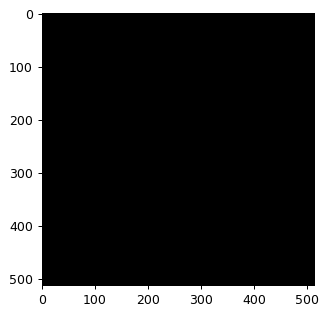

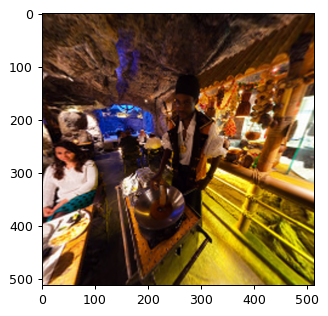

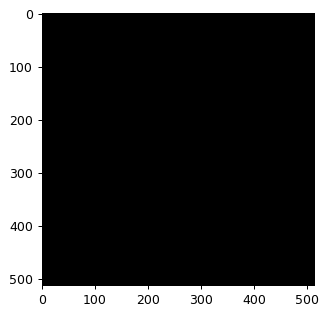

ZeroDivisionError: division by zero

In [11]:
renders = {
    "phong": None,
    "silhouette": None,
    "events": None
}
variation = ["dist", "elev"]
pepper = ["dist", "elev"]
random_start = ["azim", "elev", "dist"]


done = ["bottle-square", "car-beetle", "sofa", "chair_plastic"]
#Iterate over each mesh
for name, mesh in meshes.items():
    
    """Augmentation scenarios (all trajectories complete full 360 w/ simulated handshake)
        -normal trajectory
        -varying distance
        -
    """
    if name in done:
        continue
    
    count = 0
    while count != RenderParams.mesh_iter:
        
        
        #Create a random trajectory
        cam_poses = cam_trajectory(
            variation= variation,
            pepper = pepper,
            random_start= random_start
        )
        
        mesh, translation = mesh_random_translation(mesh, .5)
        
        background = None
        
        render_manager = RenderManager(
            types=list(renders.keys()),
            mesh_name = name,
            new_folder = "train",
            metadata = {
                "augmentation_params": {
                    "variation": variation,
                    "pepper": pepper,
                    "random_start": random_start
                },
                "mesh_transformation": {
                    "translation": translation.get_matrix().cpu().numpy().tolist()
                }
            }
        )
        render_manager.init()
        # Render the teapot providing the values of R and T.
        R, T = cam_poses
        for num in range(1, len(R) + 1):
            img_dict = {}
            
            if "phong" in renders.keys():
                image_ref = phong_renderer(meshes_world=mesh, R=R[num-1:num:], T=T[num-1:num:])
                image_ref = image_ref.cpu().numpy()
                img_dict["phong"] = image_ref.squeeze()
            
            if "silhouette" in renders.keys():
                silhouette = silhouette_renderer(meshes_world=mesh, R=R[num-1:num:], T=T[num-1:num:])
                silhouette = silhouette.cpu().numpy()
                img_dict["silhouette"] = silhouette.squeeze()[...,3]
            
            #Merge with background images
            img_dict, background = merge_with_background(img_dict, background)
            break
            if RenderParams.show_frame:
                for plot_num, img in enumerate(img_dict.values()):
                    plot_num += 1
                    ax = plt.subplot(1, len(img_dict.values()), plot_num)
                    ax.imshow(img)
                plt.show()
                
            render_manager.add_images( 
                num,
                img_dict,
                R[num-1:num:], T[num-1:num:])
            
        image_path_list = [img['image_path'] for img in render_manager.images['phong']]
        event_frames = generate_events(image_path_list)
        for num, frame in enumerate(event_frames):
            render_manager.add_event_frame(num, frame)

        render_manager.close()
        count += 1


### Diff Model

In [ ]:
def neg_iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return 1. - (intersect / union).sum() / intersect.nelement()

In [ ]:
class MeshDeformationModel(nn.Module):
    
    def __init__(self, device, template_mesh = None):
        super().__init__()
        
        self.device = device
        
        #Create a source mesh
        if not template_mesh:
            template_mesh = ico_sphere(2, device)
        
        verts, faces = template_mesh.get_mesh_verts_faces(0)
        #Initialize each vert to have no tetxture
        verts_rgb = torch.ones_like(verts)[None]
        textures = Textures(verts_rgb=verts_rgb.to(self.device))
        self.template_mesh = Meshes(
            verts=[verts.to(self.device) * 1.5],
            faces=[faces.to(self.device)],
            textures = textures
        )
        
        self.register_buffer('vertices', self.template_mesh.verts_padded())
        self.register_buffer('faces', self.template_mesh.faces_padded())
        self.register_buffer('textures', textures.verts_rgb_padded())
        
        deform_verts = torch.zeros_like(self.template_mesh.verts_packed(), device=device, requires_grad=True)
        #deform_verts = torch.full(self.template_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        #Create an optimizable parameter for the mesh
        self.register_parameter('deform_verts', nn.Parameter(deform_verts).to(self.device))
        
        laplacian_loss = mesh_laplacian_smoothing(template_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(template_mesh)
        
    def forward(self, batch_size):
        #Offset the mesh
        deformed_mesh_verts = self.template_mesh.offset_verts(self.deform_verts)
        texture = Textures(verts_rgb = self.textures)
        deformed_mesh = Meshes(verts=deformed_mesh_verts.verts_padded(), faces=deformed_mesh_verts.faces_padded(), textures=texture)
        deformed_meshes = deformed_mesh.extend(batch_size)
    
        laplacian_loss = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(deformed_mesh)
        
        return deformed_meshes, laplacian_loss, flatten_loss
    

# EVENT-BASED Optimization 

### Initialize the model

In [ ]:
weight_ssd = 1
weight_laplacian = .01
weight_flatten = .0001

batch_size = 128

# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, template mesh and reference image
model = MeshDeformationModel(device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.5, 0.99)) #Hyperparameter tuning

render = RenderManager.from_directory(dir_num=60)
R, T = render._trajectory
#images_gt = render._images(type_key = "silhouette").to(device)
events = torch.true_divide(render._events().to(device), 255)
print(events.shape)
cameras = SfMPerspectiveCameras(device=device, R=R, T=T)
print(R.shape)

### Run the optimization

In [ ]:
loop = tqdm_notebook(range(2000))
laplacian_losses = []
flatten_losses = []
ssd_losses = []

for i in loop:
    
    mesh, laplacian_loss, flatten_loss = model(batch_size)

    #The events were also generated with phong renderer
    images_pred = phong_renderer(mesh.clone(), device=device, cameras=cameras)
    events_pred = []
    prev_img = images_pred[0]
    for img in images_pred[1:-1]:
        ev = event_renderer(prev_img.detach().cpu().squeeze(), img.detach().cpu().squeeze(), "phong")
        events_pred.append(torch.from_numpy(ev))
    events_pred = torch.stack(events_pred).to(device)
    
    #silhouette_loss = neg_iou_loss(images_gt, images_pred)
    ssd_loss = torch.sum((events[0:batch_size-2] - events_pred) ** 2)
    
    loss = ssd_loss * weight_ssd + laplacian_loss * weight_laplacian + flatten_loss * weight_flatten
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    ssd_losses.append(ssd_loss * weight_ssd)
    laplacian_losses.append(laplacian_loss * weight_laplacian)
    flatten_losses.append(flatten_loss * weight_flatten)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        #Write images
        image = images_pred.detach().cpu().numpy()[0]
        writer.append_data((255*image).astype(np.uint8))
        imageio.imsave(f"data/dump/mesh_{i}.png", (255*image).astype(np.uint8))
        
        f, (ax1, ax2) = plt.subplots(1, 2)
        
        image = img_as_ubyte(image)
        ax1.imshow(image)
        ax1.set_title("Deformed Mesh")
        
        ax2.plot(silhouette_losses, label="Silhouette Loss")
        ax2.plot(laplacian_losses, label="Laplacian Loss")
        ax2.plot(flatten_losses, label="Flatten Loss")
        ax2.legend(fontsize="16")
        ax2.set_xlabel("Iteration", fontsize="16")
        ax2.set_ylabel("Loss", fontsize="16")
        ax2.set_title("Loss vs iterations", fontsize="16")
        
        plt.show()